
## Potential Field Path Planning



## Task

1. Define a Workspace with some obstacles.  
2. Determine the initial point of movement, the final point.
3. Write a program for planning a path from the initial point to the final point bypassing obstacles using the potential field method.
4. The program code must reflect all the steps for constructing the potential field of the workspace, the order of calculating the gradient, and determining the subsequent direction of movement.
5. Illustrate achieved results.
6. Prepare a report in `.ipynb`

 >Contents of reports:
 > 1. Title
 > 2. Task of work  
 > 3. Code of final program  
 > 4. Description of commands
 > 5. illustrating stages of program execution
 > 6. conclusions based on the results of the work.  


### 0. Import the necessary libraries  

In [1]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import matplotlib.patches as patches
from math import pi
import numpy as np
import matplotlib.patches as patches
from shapely.geometry import Polygon, LineString, Point
import networkx as nx
from shapely.ops import unary_union
from scipy.spatial import KDTree
import random
from shapely.geometry import Point
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


1. Define some obstacles

In [2]:
# Define the obstacles as polygons
obstacles = [
    Polygon([(1, 1), (4, 4), (4, 1)]),
    Polygon([(5, 4), (6, 5), (6, 3)]),
    Polygon([(7, 3), (8, 3), (7, 2)]),
    Polygon([(2, 4), (3, 4), (3, 5)]),
    Polygon([(2, 6), (3,6), (5, 6), (3, 5)]),
    Polygon([(6, 8), (5,8), (5, 6)]),
    Polygon([(5, 2), (6, 1), (6, 3), (5, 3)])

]

2. Define the workspace

In [3]:
# Define the workspace boundary
boundary = Polygon([(0, 0), (9, 0), (9, 9), (0, 9)])

3. Define start and your goal points

In [4]:
# Define start and goal points
start_point = Point(1, 3)      # Example coordinates
goal = np.array([7, 7])


## 4.Find collision-free space

**Collision of the Robot with an Obstacle**

The collision of the robot with an obstacle is defined as:

&nbsp;&nbsp;&nbsp;&nbsp;**Qˣ = { q ∈ Q | R(q) ⋂ O ≠ ∅ }**

where:

- **Q** is the configuration space,
- **R(q)** is the region occupied by the robot at configuration **q**,
- **O** is the obstacle.

The **collision-free space** is expressed as:

&nbsp;&nbsp;&nbsp;&nbsp;**Q₀ = Q ∖ Qˣ**

---

In [5]:
# Subtract obstacles from the workspace to get free space
free_space = boundary
for obs in obstacles:
    free_space = free_space.difference(obs)

# Combine all obstacles into one geometry for fast distance
collision_area = unary_union(obstacles)

### 5. write your program


**Path Planning**

To plan the path, the **attractive potential** is defined as:

&nbsp;&nbsp;&nbsp;&nbsp;**Pₐ(q) = (1 / 2) kₐ || q − q_d ||²**

where:

- **q** is the current configuration,
- **q_d** is the desired (goal) configuration,
- **kₐ** is a positive scaling factor for the attractive potential.
---

In [6]:
# Parameters
k_a = 100.0       # Attraction gain
k_r = 60.0       # Strong repulsion gain
delta_0 = 2.0    # Repulsion influence radius

#attractive_potential(q)`: computes attraction to goal
def attractive_potential(q):
    return 0.5 * k_a * np.linalg.norm(q - goal)**2


**Repulsive Potential Function**

The repulsive potential \( P_r(\mathbf{q}) \) ensures a singularity in the function \( P(\mathbf{q}) \) when the material point approaches the collision space. It is defined as:

\[
P_r(\mathbf{q}) =
\begin{cases}
\frac{1}{2} k_r \left( \frac{1}{\delta(\mathbf{q})} - \frac{1}{\delta_0} \right)^2 & \text{if } \delta(\mathbf{q}) \leq \delta_0 \\
0 & \text{if } \delta(\mathbf{q}) > \delta_0
\end{cases}
\]

Where:

- \( \mathbf{q} = [x, y]^T \) is the position of the robot or particle,
- \( \delta(\mathbf{q}) \) is the Euclidean distance from point \( \mathbf{q} \) to the nearest obstacle (collision area),
- \( \delta_0 \) is the threshold distance beyond which the repulsive potential is zero,
- \( k_r \) is a positive gain controlling the strength of the repulsive field.


In [7]:
#repulsive_potential(q): computes repulsion from obstacles

def repulsive_potential(q):
    point = Point(q[0], q[1])
    dist = point.distance(collision_area)
    eps = 1e-6
    dist = max(dist, eps)  # Avoid division by zero

    if dist > delta_0:
        return 0
    else:
        return 0.5 * k_r * (1.0 / dist - 1.0 / delta_0) ** 2


**Potential Field Approach**

The robot is considered as a material point moving in the configuration space under the influence of a **potential field function**:

&nbsp;&nbsp;&nbsp;&nbsp;**P(q) = Pₐ(q) + Pᵣ(q)**

where:

- **Pₐ(q)** is the attractive potential assigned to the goal configuration,
- **Pᵣ(q)** is the repulsive potential assigned to the collision space.

---


In [8]:
def total_potential(q):
    return attractive_potential(q) + repulsive_potential(q)

**Implement the Path Planning Loop Using Gradient Descent**
The gradient descent algorithm can be used to plan a path:

&nbsp;&nbsp;&nbsp;&nbsp;**qᵢ₊₁ = qᵢ − γᵢ ∇P(qᵢ)**

where:

- ∇P(q) = [∂P/∂q₁, ∂P/∂q₂, ..., ∂P/∂qₙ]ᵀ
is the gradient of the potential function,
- γᵢ is an iterative step size. It can be:
  - Fixed,
  - Fractional,
  - Or computed as the best step along the descent direction:

&nbsp;&nbsp;&nbsp;&nbsp;**γᵢ = argminᵢ P(qᵢ − γ ∇P(qᵢ))**


In [9]:
#grad_potential(q)`: computes gradient of total field

def grad_potential(q, eps=1e-3):
    grad = np.zeros(2)
    for i in range(2):
        dq = np.zeros(2)
        dq[i] = eps
        forward = total_potential(q + dq)
        backward = total_potential(q - dq)
        grad[i] = (forward - backward) / (2 * eps)
    return grad

In [10]:
#trajectory: list of robot positions from start to goal


# Initialize
q = np.array(start_point.coords[0])
trajectory = [q.copy()]
step_size = 0.000001
max_iters = 10000000
tolerance = 0.1

for _ in range(max_iters):
    if np.linalg.norm(q - goal) < tolerance:
        print(" Goal reached.")
        q = goal.copy()  # optionally snap to goal
        goal_reached = True
        break

    grad = grad_potential(q)
    q = q - step_size * grad
    trajectory.append(q.copy())

if goal_reached:
    # Optional: plot or save path here
    print(" Path planning completed successfully.")
else:
    print(" Goal NOT reached within max iterations.")

 Goal reached.
 Path planning completed successfully.


### 6. Illustrate the Results Section
 > Sample plot available in the presentation file.

In [11]:

# Grid setup
x = np.linspace(0, 10, 100)
y = np.linspace(0, 10, 100)
X, Y = np.meshgrid(x, y)
Z_att = np.zeros_like(X)
Z_rep = np.zeros_like(X)
Z_total = np.zeros_like(X)


In [12]:
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        q = np.array([X[i, j], Y[i, j]])
        Z_att[i, j] = attractive_potential(q)
        Z_rep[i, j] = repulsive_potential(q)
        Z_total[i, j] = Z_att[i, j] + Z_rep[i, j]


In [13]:
# Normalize potentials for visual clarity
Z_att_norm = Z_att / np.max(Z_att)
Z_rep_norm = Z_rep / np.max(Z_rep)
Z_total_norm = Z_att_norm + Z_rep_norm

### (a) visualize Configuration Space Q

The **configuration space Q** represents all possible configurations of the robot.


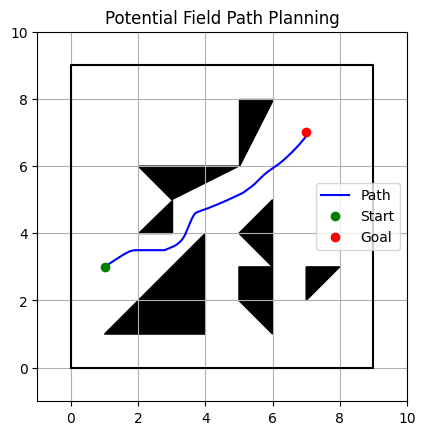

In [14]:
fig, ax = plt.subplots()

# Draw obstacles
for obs in obstacles:
    patch = patches.Polygon(np.array(obs.exterior.coords), color='black')
    ax.add_patch(patch)

# Draw workspace boundary
x, y = boundary.exterior.xy
ax.plot(x, y, 'black')

# Draw path
trajectory = np.array(trajectory)
ax.plot(trajectory[:, 0], trajectory[:, 1], 'b-', label='Path')

# Start and goal points
ax.plot(start_point.x, start_point.y, 'go', label='Start')
ax.plot(goal[0], goal[1], 'ro', label='Goal')

ax.set_xlim(-1, 10)
ax.set_ylim(-1, 10)
ax.set_aspect('equal')
ax.legend()
plt.grid(True)
plt.title("Potential Field Path Planning")
plt.show()

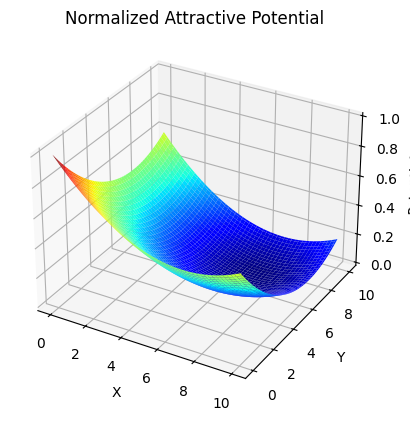

In [16]:
### (b) Attractive Potential (Normalized)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_att_norm, cmap=cm.jet)
ax.set_title("Normalized Attractive Potential")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Potential')
plt.show()

### (b) visualize Setting the Attractive Component of the Potential Field
The **attractive potential component** pulls the robot towards the goal configuration.



Text(0.5, 0, 'Potential')

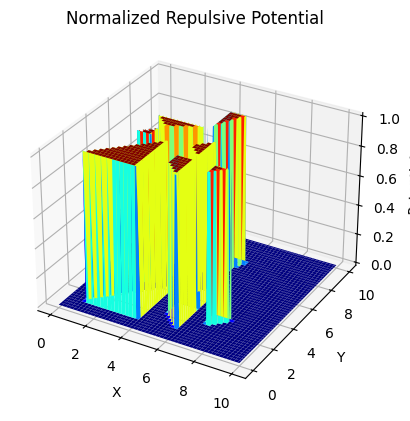

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_rep_norm, cmap=cm.jet)
ax.set_title("Normalized Repulsive Potential")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Potential')

### (d) visualize Combining the Attractive and Repulsive Components

The **combined potential field** is formed by adding the attractive and repulsive components.


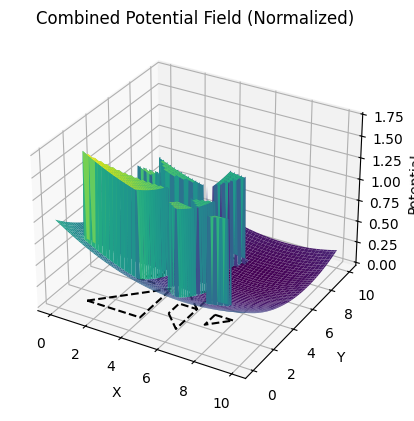

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_total_norm, cmap='viridis')
ax.set_title("Combined Potential Field (Normalized)")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Potential')

# Optional: draw obstacles
for obs in obstacles:
    x, y = obs.exterior.xy
    ax.plot(x, y, 'k--', zdir='z', zs=0)

plt.show()

### (e) visualize Solving the Optimization Problem of Finding the Global Minimum

The **global minimum of the potential field function** corresponds to the goal configuration, found by solving an optimization problem.


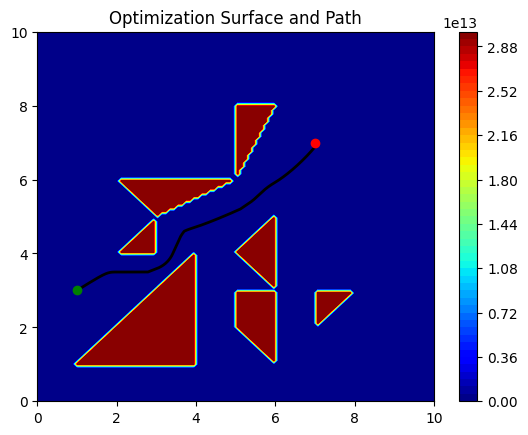

In [28]:
fig, ax = plt.subplots()
contour = ax.contourf(X, Y, Z_total, levels=50, cmap='jet')
plt.colorbar(contour)
trajectory = np.array(trajectory)
ax.plot(trajectory[:, 0], trajectory[:, 1], 'k-', linewidth=2)
ax.plot(start_point.x, start_point.y, 'go')
ax.plot(goal[0], goal[1], 'ro')
ax.set_title("Optimization Surface and Path")
plt.show()


### (f) visualize Defining the Path Connecting the Start and Goal Configurations

The **resulting path** is defined by following the gradient of the potential field from the start configuration to the goal configuration.


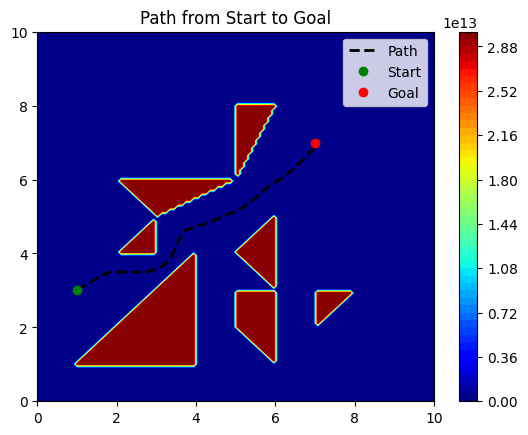

In [29]:
fig, ax = plt.subplots()
contour = ax.contourf(X, Y, Z_total, levels=50, cmap='jet')
plt.colorbar(contour)
ax.plot(trajectory[:, 0], trajectory[:, 1], 'k--', linewidth=2, label='Path')
ax.plot(start_point.x, start_point.y, 'go', label='Start')
ax.plot(goal[0], goal[1], 'ro', label='Goal')
ax.legend()
ax.set_title("Path from Start to Goal")
plt.show()



## Conclusions
- The robot successfully reached the goal by following the gradient of the potential field.
- Obstacles were avoided using repulsive fields.
- The method is sensitive to local minima and parameter tuning.